In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dataset_1 = pd.read_excel("/content/Dataset_1.xlsx")

In [4]:
dataset_2 = pd.read_excel("/content/Dataset_2.xlsx", header=None, names=['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9'])

In [6]:
data = pd.concat([dataset_1, dataset_2], axis=0, ignore_index=True)

In [7]:
print(data.shape)

(1048577, 22)


In [8]:
# Weight settings:
# - weight_first_click: First click weight set to 0.5, as it indicates initial interest.
# - weight_position_based: Position-based click weight set to 0.3, representing the supportive role of intermediate clicks in conversion.
weight_first_click = 0.5
weight_position_based = 0.3

In [9]:
data['attribution_score'] = 0

In [37]:
def calculate_attribution_score(row):
    if row['conversion'] == 1 and row['attribution'] == 1:
        if row['click_pos'] == 0:
            score = weight_first_click
        else:
            score = weight_position_based
        if row['click_nb'] > 1:
        # - Log adjustment for multiple clicks to prevent repeated clicks from overly influencing the total score.
            click_weight = 1 + np.log(row['click_nb'] + 1)
            score *= click_weight
    else:
        score = 0
    return score


In [38]:
data['attribution_score'] = data.apply(calculate_attribution_score, axis=1)

In [39]:
campaign_attribution = data.groupby('campaign')['attribution_score'].sum().reset_index()

In [40]:
print("Campaign Attribution Scores:\n", campaign_attribution)

Campaign Attribution Scores:
      campaign  attribution_score
0       73322           3.124924
1       73325          18.694427
2       73327          22.180575
3       73328          41.160089
4       83677          12.283952
..        ...                ...
665  32398755          25.904842
666  32398758           5.152916
667  32405311           8.629959
668  32452108           0.629584
669  32452111         181.852533

[670 rows x 2 columns]


In [41]:
top_campaigns = campaign_attribution.sort_values(by='attribution_score', ascending=False)
top_10_fixed = top_campaigns.head(10)

In [42]:
print("Top 10 Campaigns with Highest Attribution Scores:\n", top_10_fixed)

Top 10 Campaigns with Highest Attribution Scores:
      campaign  attribution_score
663  32368244        1440.634893
215  10341182        1396.134344
324  15184511         756.864271
635  30801593         707.852212
195   9100689         557.284109
652  31772643         517.403906
327  15398570         516.261906
199   9100693         510.778679
111   5544859         431.086580
570  28351001         403.503309


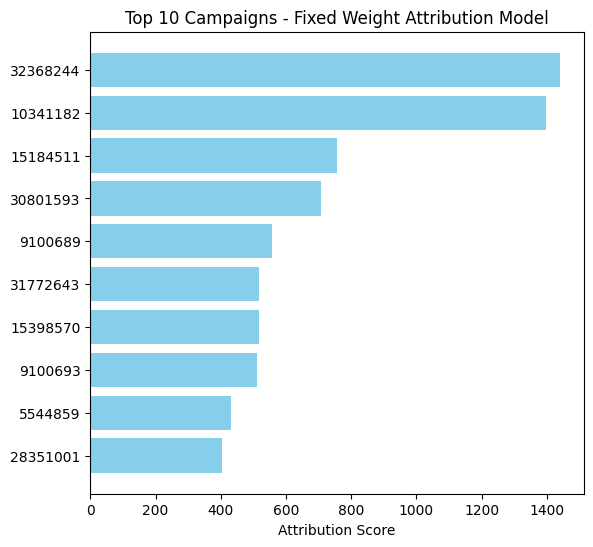

In [43]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.barh(top_10_fixed['campaign'].astype(str), top_10_fixed['attribution_score'], color="skyblue")
plt.title("Top 10 Campaigns - Fixed Weight Attribution Model")
plt.xlabel("Attribution Score")
plt.gca().invert_yaxis()


**Heuristic Model with Fixed Weights:**
This model applies fixed weights for different click types, assigning higher weight to the first click (0.5) and a lower weight (0.3) to intermediate clicks, with a logarithmic adjustment for repeated clicks. By giving prominence to the first interaction, this model is geared toward understanding which campaign or content initially engaged the user. It assumes that early engagement is a strong predictor of conversion likelihood, while middle interactions play a secondary, supportive role. This approach gives a balanced attribution but may not capture the influence of time since the last click effectively.

In [16]:
weight_first_click = 0.5
weight_position_based = 0.3
decay_factor = 0.9

In [17]:
def calculate_attribution_score(row):
    score = 0
    if row['conversion'] == 1 and row['attribution'] == 1:
        # First-click weight
        if row['click_pos'] == 0:
            score = weight_first_click
        # Position-based weight with recency decay
        else:
            time_decay = decay_factor ** row['time_since_last_click']
            score = weight_position_based * time_decay

        # Adjust for multiple clicks using logarithmic scale
        if row['click_nb'] > 1:
            click_weight = 1 + np.log(row['click_nb'] + 1)
            score *= click_weight
    return score

In [18]:
data['attribution_score'] = data.apply(calculate_attribution_score, axis=1)
campaign_attribution = data.groupby('campaign')['attribution_score'].sum().reset_index()

In [19]:
print("Campaign Attribution Scores:\n", campaign_attribution)

Campaign Attribution Scores:
      campaign  attribution_score
0       73322           2.337447
1       73325           7.443314
2       73327          16.698961
3       73328          25.600000
4       83677           4.572207
..        ...                ...
665  32398755           7.330333
666  32398758           1.972955
667  32405311           1.395880
668  32452108           0.000000
669  32452111          53.655232

[670 rows x 2 columns]


In [32]:
top_campaigns = campaign_attribution.sort_values(by='attribution_score', ascending=False)
top_10_decay = top_campaigns.head(10)

In [34]:
print("Top 10 Campaigns with Highest Attribution Scores:\n", top_10_decay)

Top 10 Campaigns with Highest Attribution Scores:
      campaign  attribution_score
663  32368244         721.313025
215  10341182         542.498704
324  15184511         397.575627
199   9100693         394.845035
195   9100689         354.590956
635  30801593         330.302034
52    2869134         329.800506
111   5544859         319.717840
347  16184517         295.447390
652  31772643         199.568130


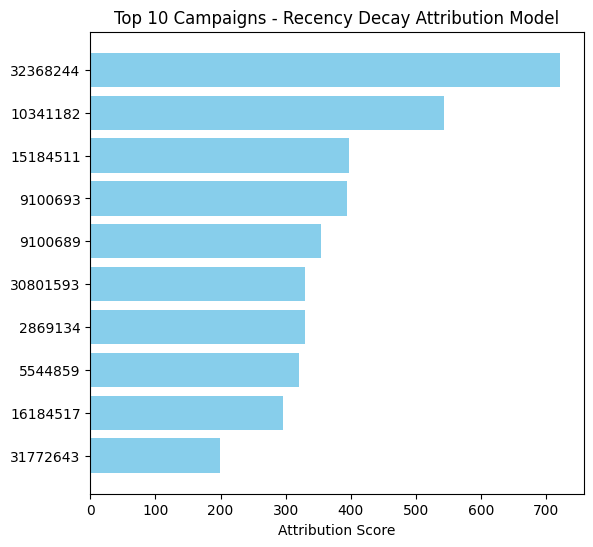

In [36]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.barh(top_10_decay['campaign'].astype(str), top_10_decay['attribution_score'], color="skyblue")
plt.title("Top 10 Campaigns - Recency Decay Attribution Model")
plt.xlabel("Attribution Score")
plt.gca().invert_yaxis()

**Heuristic Model with Recency Decay:**
In this version, a decay factor is applied to account for the time since the last click. The Recency Decay model introduces a decay factor (0.9) that decreases the impact of earlier clicks as time passes, favoring more recent interactions. This is based on the assumption that clicks closer to the conversion event are more indicative of purchase intent.  The decay factor assumes that as time elapses, prior clicks lose relevance, so more recent engagements are better predictors of conversion. This approach ensures that more recent interactions carry greater weight, which can better reflect real customer behavior patterns, particularly in campaigns with multiple or spread-out touchpoints.

The Heuristic Model with Recency Decay is likely to perform better in capturing realistic attribution, especially in complex journeys where recent actions are more impactful on conversions. It provides a more dynamic score that reflects the influence of timing, which is an essential factor in many customer journeys. However, if simplicity and interpretability are prioritized, the fixed-weight model may be preferred, as it’s easier to implement and understand.

